In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
import scipy as sp
import os
from sklearn.metrics import mean_squared_error
import pickle
from matplotlib import gridspec
import pandas as pd
from scipy import stats
import matplotlib.legend_handler

In [2]:
params = { 'figure.figsize': (15.,5.),
          'axes.labelsize': 22,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'legend.fontsize': 16,
          'font.sans-serif': 'Arial',
          'lines.linewidth': 2}
plt.rcParams.update(params)

In [3]:
colors = ["#377eb8", "#ff7f00", "#4daf4a"]

## Read the data of AVM patients

In [4]:
folderpath = r"../data/clinical_data/"
filepaths = [os.path.join(folderpath, name) for name in os.listdir(folderpath)]
patients = []
for i in range(len(filepaths)):
    patients.append(str.split(os.path.basename(filepaths[i]), '-')[0])
patients = np.unique(patients)

In [5]:
patients_AA = ['G2', 'K1', 'K3', 'R1', 'S2']
patients_AVM = ['G1', 'K2', 'L1', 'S1', 'S3']

In [6]:
P = {}
V = {}
for i in range(len(filepaths)):
    if (str.split(os.path.basename(filepaths[i]), '-')[1] == 'AVM'):
        P[i] = np.loadtxt(filepaths[i]+"/data_p.txt")
        V[i] = np.loadtxt(filepaths[i]+"/data_v.txt")

In [7]:
for i in P.keys():
    P[i] = P[i]*100 #pressure in mmHg

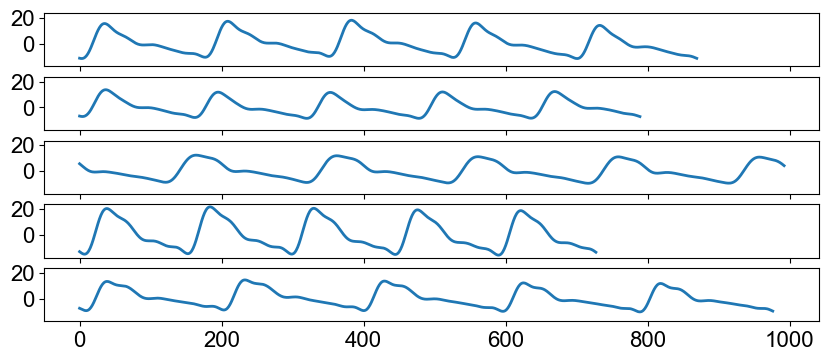

In [8]:
fig, axs = plt.subplots(ncols=1, nrows=5, sharex=True, sharey=True, figsize=(10,4))
axs = axs.ravel()
for idx, i in enumerate(list(P.keys())[:5]):
    axs[idx].plot(P[i])

In [9]:
def Heun(f, y0, t):  # Heun integrator
    y = np.zeros((len(t),len(y0)))
    y[0] = y0
    for i in range(len(t)-1):
        dt = t[i+1] - t[i]
        y_tilde = y[i] + dt*f(y[i],t[i],v[i]) # Euler formulation
        y[i+1] = y[i] + 0.5*dt*(f(y[i],t[i],v[i])+f(y_tilde,t[i]+dt,v[i+1]))
    return y

In [10]:
dt = 1/200

## state variables

In [11]:
# p and pdot are the state variables for a second order ODE model discovery
states = {}
for i in P.keys():
    states[i] = np.vstack([P[i], np.gradient(P[i], dt), V[i]])

## construct the candidate library

In [12]:
lib_V = ps.PolynomialLibrary(degree=1, include_bias=False, include_interaction=False)
lib_P = ps.PolynomialLibrary(degree=3, include_bias=False, include_interaction=True)
lib = ps.GeneralizedLibrary([lib_P, lib_V], inputs_per_library=np.array([[0,1],[2,2]]))

In [13]:
feature_names = ["p", "p'", "v"]

## calculate the numerical derivatives

In [14]:
#for the left hand side of the ODEs, we need pdot and pdotdot
derivatives = {}
for i in P.keys():
    derivatives[i] = np.zeros_like(states[i])
    for j in range(3):
        derivatives[i][j] = np.gradient(states[i][j,:], dt)

## model discovery

In [15]:
scikit_optimizer = ps.STLSQ(threshold=.1, alpha=0., fit_intercept=False)
coeff = {}
for i in P.keys():
    model = ps.SINDy(optimizer=scikit_optimizer, feature_library=lib, 
                        feature_names=feature_names).fit(states[i].T, t=dt, x_dot=derivatives[i][:2].T, quiet=True)
    coeff[i] = model.coefficients()
    model.print(lhs=['dotp', 'ddotp', 'v'])

dotp = 1.000 p'
ddotp = -174.015 p + -19.523 p' + 1.072 p^2 + -1.108 p p' + -0.797 p^3 + 23270.185 v
dotp = 1.000 p'
ddotp = -73.533 p + 4.334 p' + 5.279 p^2 + -2.142 p p' + -1.791 p^3 + 6654.838 v
dotp = 1.000 p'
ddotp = -114.986 p + 0.581 p' + -0.352 p^2 + -1.695 p p' + 2622.063 v
dotp = 1.000 p'
ddotp = -226.383 p + -18.735 p' + 1.212 p^2 + -0.883 p p' + -0.479 p^3 + 24823.671 v
dotp = 1.000 p'
ddotp = -144.190 p + -2.531 p' + 3.615 p^2 + -2.253 p p' + -1.319 p^3 + 16038.147 v
dotp = 1.000 p'
ddotp = -74.224 p + -6.841 p' + 4.167 p^2 + -2.831 p p' + -1.406 p^3 + 0.439 p^2 p' + 2851.819 v
dotp = 1.000 p'
ddotp = -294.760 p + -5.637 p' + 3.310 p^2 + -3.009 p p' + -0.249 p^3 + 12984.862 v
dotp = 1.000 p'
ddotp = -379.697 p + -20.546 p' + -0.810 p^2 + -0.987 p p' + -0.403 p^3 + 62152.506 v
dotp = 1.000 p'
ddotp = -206.250 p + -17.340 p' + 0.756 p^2 + -0.765 p p' + -0.212 p^3 + 55019.354 v
dotp = 1.000 p'
ddotp = -198.162 p + -13.723 p' + 0.458 p^2 + -1.425 p p' + 11933.844 v
dotp = 1.00

## simulations of predicted models

In [16]:
def predicted_pressure(u,t,v):
    return np.array([u[1],
                     coef[0]*u[0] + coef[1]*u[1] + coef[2]*u[0]**2 + coef[3]*u[0]*u[1] + coef[4]*u[1]**2 
                     + coef[5]*u[0]**3 + coef[6]*(u[0]**2)*u[1] + coef[7]*u[0]*(u[1]**2) + coef[8]*u[1]**3 + coef[9]*v])

In [17]:
predicted_p = {}
for i in P.keys():
    v = V[i] #include the emprical velocity in the simulations of predicted models
    coef = coeff[i][1]
    time = np.array([j*dt for j in range(len(P[i]))])
    predicted_p[i] = Heun(predicted_pressure, [P[i][0], 0.], time) #initial value is chosen from the empirical pressure

/var/folders/1l/p94fc3xx4rd6089ws07w4zfc0000gn/T/ipykernel_39950/553368757.py:4: RuntimeWarning: overflow encountered in scalar power
  + coef[5]*u[0]**3 + coef[6]*(u[0]**2)*u[1] + coef[7]*u[0]*(u[1]**2) + coef[8]*u[1]**3 + coef[9]*v])
/var/folders/1l/p94fc3xx4rd6089ws07w4zfc0000gn/T/ipykernel_39950/553368757.py:4: RuntimeWarning: invalid value encountered in scalar multiply
  + coef[5]*u[0]**3 + coef[6]*(u[0]**2)*u[1] + coef[7]*u[0]*(u[1]**2) + coef[8]*u[1]**3 + coef[9]*v])


In [19]:
non_problematic_keys = [3, 8, 9, 12, 13, 16, 17, 18, 20, 23, 26, 29]

## comparison between the simulated pressure and empirical pressure

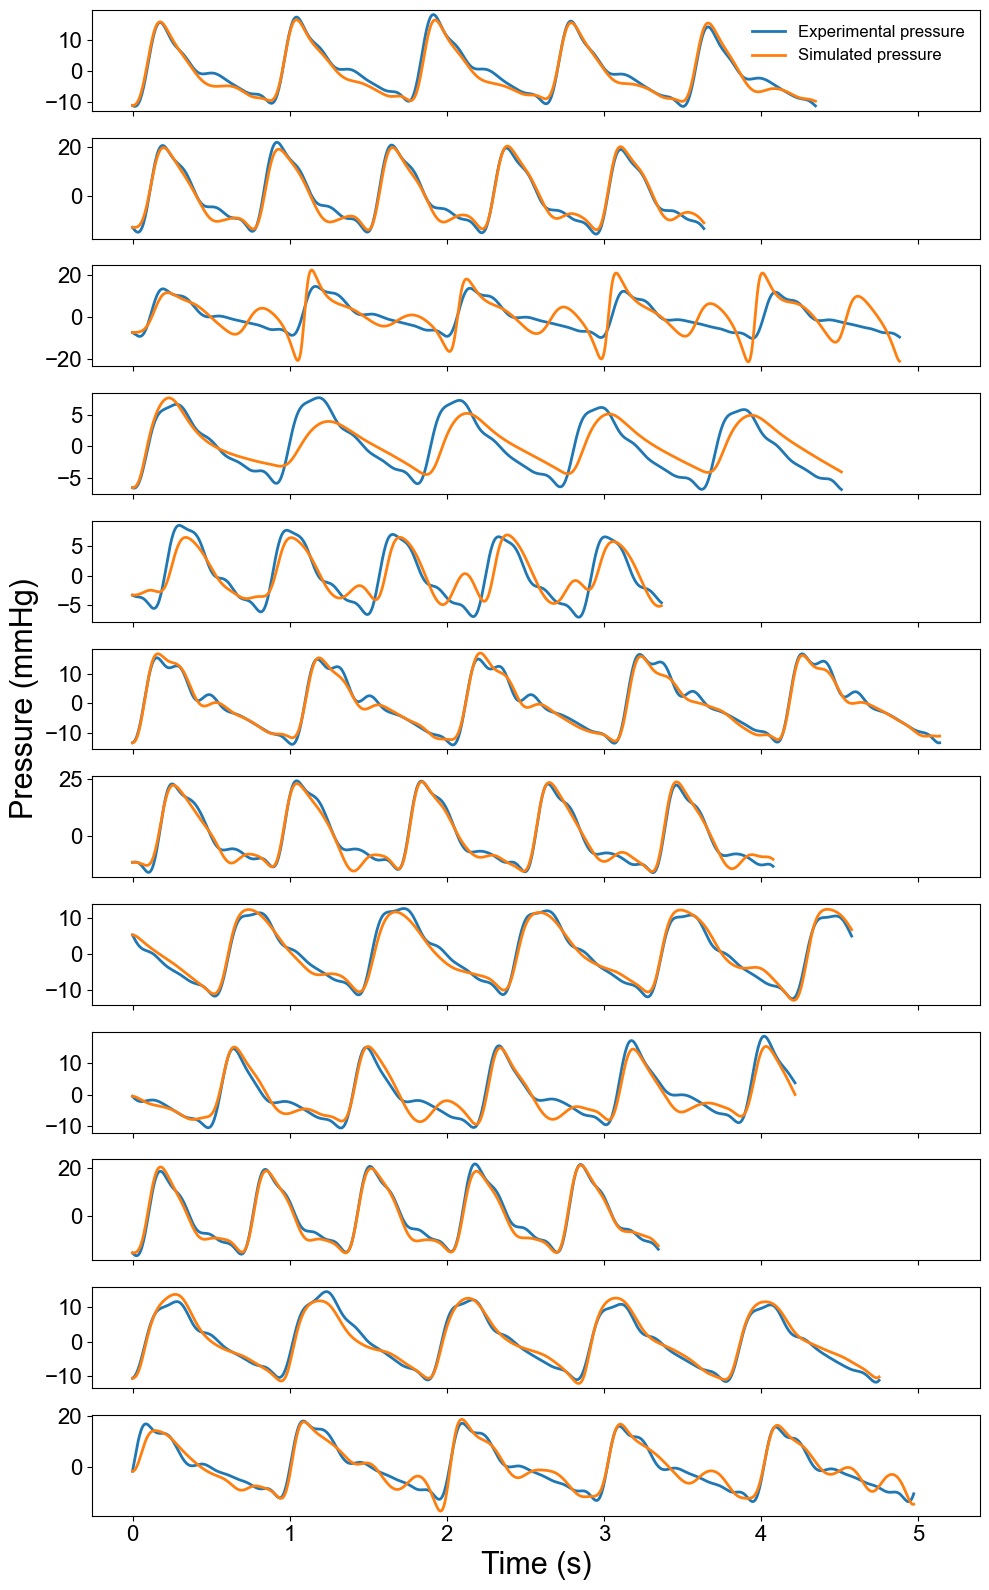

In [24]:
fig, axs = plt.subplots(nrows=12, ncols=1, figsize=(10,16), sharex=True)
axs = axs.ravel()
for idx, i in enumerate(non_problematic_keys):
    axs[idx].plot(np.array([k*dt for k in range(len(P[i]))]), P[i], label="Experimental pressure")
    axs[idx].plot(np.array([k*dt for k in range(len(P[i]))]), predicted_p[i][:,0], label="Simulated pressure")
    
axs[11].set_xlabel("Time (s)")
axs[5].set_ylabel("Pressure (mmHg)")
axs[0].legend(frameon=False, fontsize=12)
fig.tight_layout()